In [1]:
from _ROTOR import rotor 
from _MISSION_PLANNER import MissionPlanner
import numpy as np
import matplotlib.pyplot as plt 

### plotting the variations of forces and moments with the given control inputs 

In [8]:
import numpy as np
# Create rotor instance
x = rotor()
radius=  5
root_cut_out = 0.8
chord_root = 0.3
chord_tip = 0.1
# Set more realistic rotor parameters
x.set_rotor(
    radius=radius,        # m
    root_cut_out=root_cut_out,  # m
    chord0=chord_root,       
    chord_slope= (chord_tip - chord_root)/(radius-root_cut_out),
    blades=3,
    omega=23,           # rad/s (~238 RPM)
    twist0= np.deg2rad(0),
    twist_slope= np.deg2rad(3)/(radius-root_cut_out)
)
x.atmosphere(h=2000)

(275.15, 94218.07928359076, 1.154950429497074, 332.5274883374305)

In [9]:
# Forward flight conditions
forward_speed = 55.55  # m/s
alpha_tpp = np.deg2rad(3)

theta0 = np.deg2rad(8)
theta1c = np.deg2rad(0)
theta1s = np.deg2rad(0)

# Compute forces and flapping angles
forces_moments, R_grid, PSI_grid, alpha, dT, dH, dY = x.forward(
    forward_speed=forward_speed,
    theta0=theta0,
    theta1c=theta1c,
    theta1s=theta1s,
    alpha_tpp=alpha_tpp
)

# Print relevant outputs
print("FZ (Thrust) [N]:", forces_moments['FZ'])
print("FX (Forward) [N]:", forces_moments['FX'])
print("FY (Lateral) [N]:", forces_moments['FY'])
print("beta0 [rad]:", forces_moments['beta0'])
print("beta1c [rad]:", forces_moments['beta1c'])
print("beta1s [rad]:", forces_moments['beta1s'])
print("CT (Rotor Thrust Coefficient):", forces_moments.get('CT', 'Not computed'))

FZ (Thrust) [N]: 61321.43508014134
FX (Forward) [N]: 80361.9235145067
FY (Lateral) [N]: 5697.23386960235
beta0 [rad]: 0.017453292519943295
beta1c [rad]: -0.01348911860150052
beta1s [rad]: -0.01348911860150052
CT (Rotor Thrust Coefficient): 0.017038923318091276


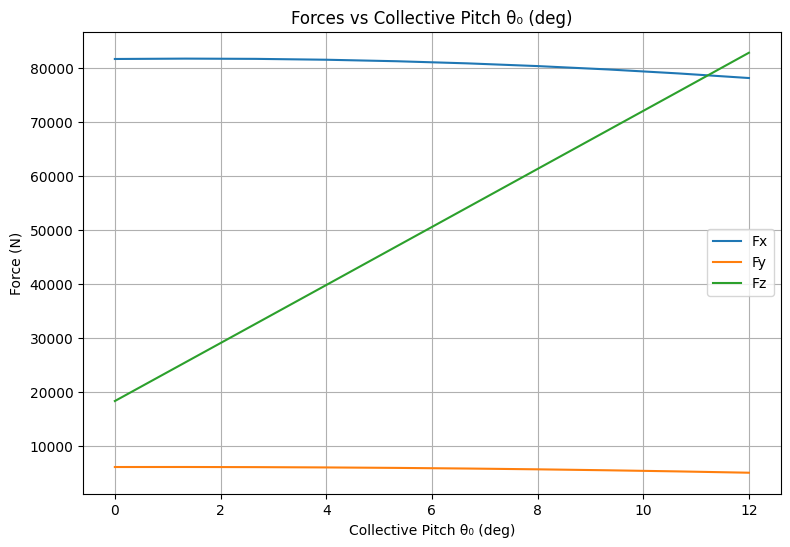

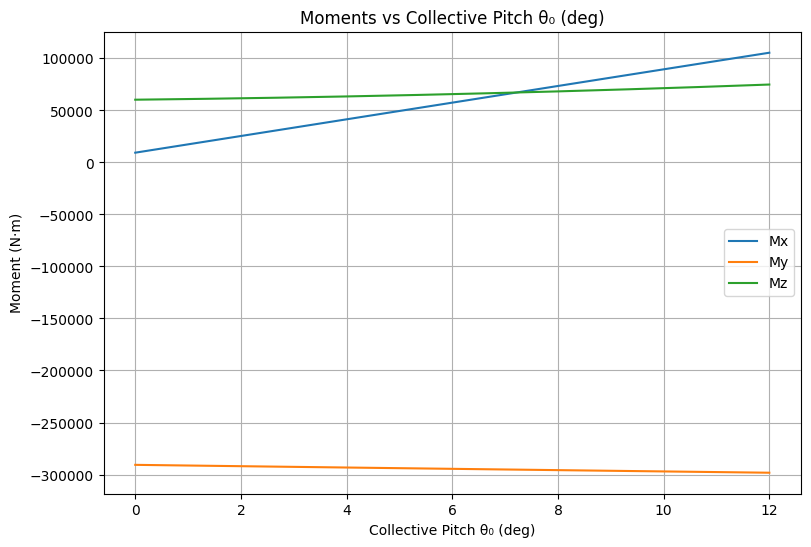

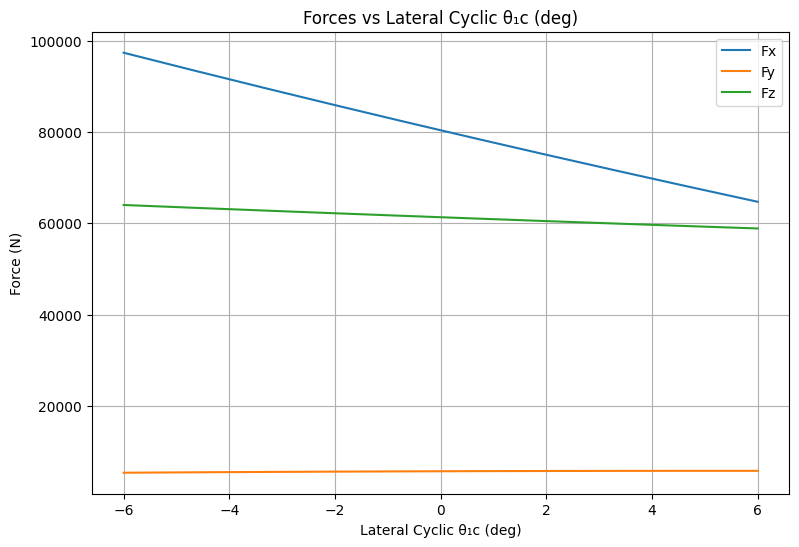

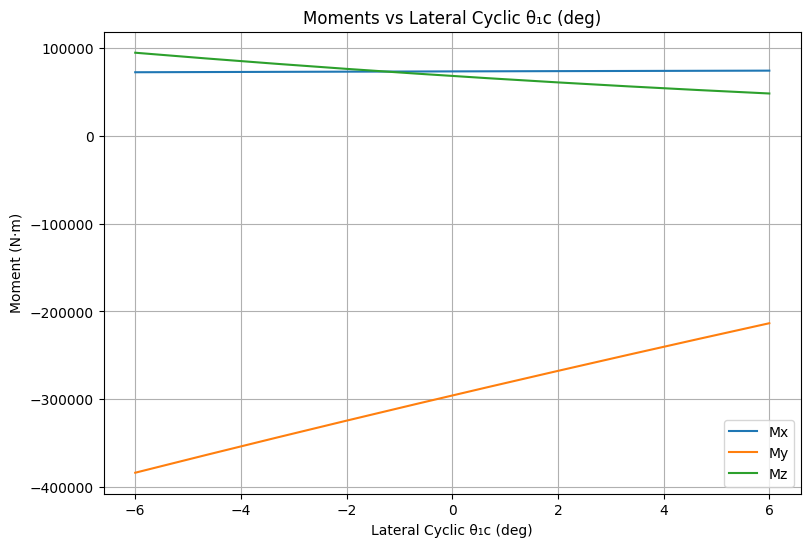

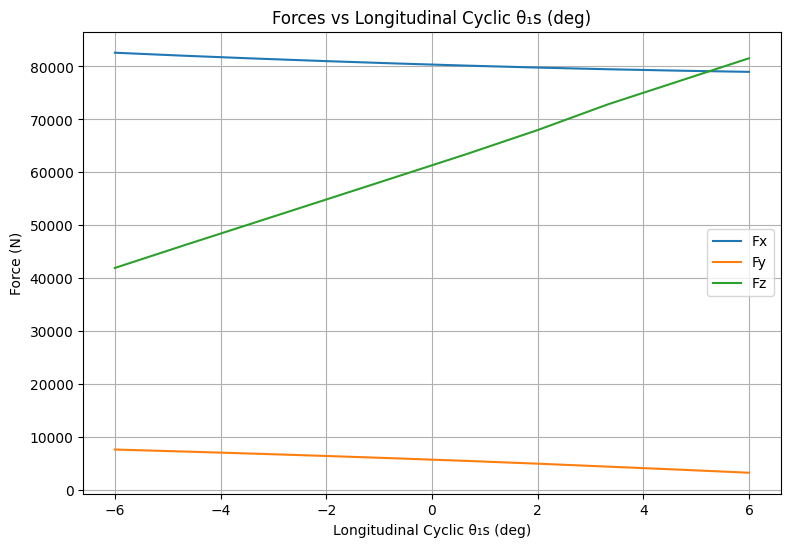

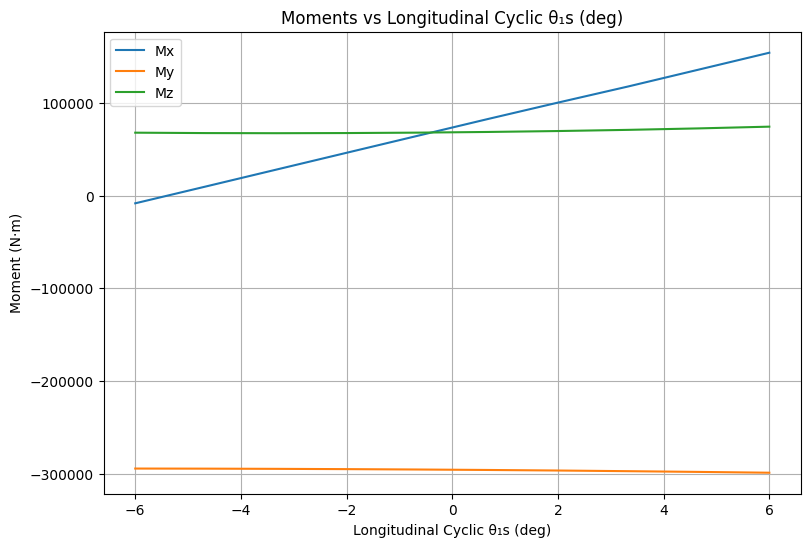

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- Fixed forward-flight condition ---
forward_speed = 55.55  # m/s
alpha_tpp = np.deg2rad(3)

# Define input ranges (in degrees)
collective_range = np.linspace(0, 12, 10)   # θ0 (collective)
cyclic_lat_range = np.linspace(-6, 6, 10)   # θ1c (longitudinal cyclic)
cyclic_lon_range = np.linspace(-6, 6, 10)   # θ1s (lateral cyclic)

# Helper function to run a sweep
def sweep_input(x, var_name, var_range, theta0_fixed, theta1c_fixed, theta1s_fixed):
    Fx, Fy, Fz, Mx, My, Mz = [], [], [], [], [], []
    for val_deg in var_range:
        theta0 = np.deg2rad(theta0_fixed)
        theta1c = np.deg2rad(theta1c_fixed)
        theta1s = np.deg2rad(theta1s_fixed)
        if var_name == "theta0":
            theta0 = np.deg2rad(val_deg)
        elif var_name == "theta1c":
            theta1c = np.deg2rad(val_deg)
        elif var_name == "theta1s":
            theta1s = np.deg2rad(val_deg)

        forces_moments, *_ = x.forward(
            forward_speed=forward_speed,
            theta0=theta0,
            theta1c=theta1c,
            theta1s=theta1s,
            alpha_tpp=alpha_tpp
        )

        Fx.append(forces_moments['FX'])
        Fy.append(forces_moments['FY'])
        Fz.append(forces_moments['FZ'])
        Mx.append(forces_moments['MX'])
        My.append(forces_moments['MY'])
        Mz.append(forces_moments['MZ'])
    return Fx, Fy, Fz, Mx, My, Mz

# --- Sweep 1: Collective pitch θ0 ---
Fx0, Fy0, Fz0, Mx0, My0, Mz0 = sweep_input(
    x, "theta0", collective_range, theta0_fixed=0, theta1c_fixed=0, theta1s_fixed=0
)

# --- Sweep 2: Longitudinal cyclic θ1c ---
Fx1c, Fy1c, Fz1c, Mx1c, My1c, Mz1c = sweep_input(
    x, "theta1c", cyclic_lat_range, theta0_fixed=8, theta1c_fixed=0, theta1s_fixed=0
)

# --- Sweep 3: Lateral cyclic θ1s ---
Fx1s, Fy1s, Fz1s, Mx1s, My1s, Mz1s = sweep_input(
    x, "theta1s", cyclic_lon_range, theta0_fixed=8, theta1c_fixed=0, theta1s_fixed=0
)

# -------------------- PLOTTING --------------------

def plot_forces(var_range, Fx, Fy, Fz, xlabel):
    plt.figure(figsize=(9,6))
    plt.plot(var_range, Fx, label='Fx')
    plt.plot(var_range, Fy, label='Fy')
    plt.plot(var_range, Fz, label='Fz')
    plt.xlabel(xlabel)
    plt.ylabel('Force (N)')
    plt.title(f'Forces vs {xlabel}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_moments(var_range, Mx, My, Mz, xlabel):
    plt.figure(figsize=(9,6))
    plt.plot(var_range, Mx, label='Mx')
    plt.plot(var_range, My, label='My')
    plt.plot(var_range, Mz, label='Mz')
    plt.xlabel(xlabel)
    plt.ylabel('Moment (N·m)')
    plt.title(f'Moments vs {xlabel}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for θ0
plot_forces(collective_range, Fx0, Fy0, Fz0, 'Collective Pitch θ₀ (deg)')
plot_moments(collective_range, Mx0, My0, Mz0, 'Collective Pitch θ₀ (deg)')

# Plot for θ1c
plot_forces(cyclic_lat_range, Fx1c, Fy1c, Fz1c, 'Lateral Cyclic θ₁c (deg)')
plot_moments(cyclic_lat_range, Mx1c, My1c, Mz1c, 'Lateral Cyclic θ₁c (deg)')

# Plot for θ1s
plot_forces(cyclic_lon_range, Fx1s, Fy1s, Fz1s, 'Longitudinal Cyclic θ₁s (deg)')
plot_moments(cyclic_lon_range, Mx1s, My1s, Mz1s, 'Longitudinal Cyclic θ₁s (deg)')


### finding trim settings using root finding method 

In [23]:
import numpy as np
from scipy.optimize import fsolve

# === Helicopter & environment parameters ===
mass = 5000       # kg
g = 9.81          # m/s^2
W = mass * g
forward_speed = 55.55  # m/s
alpha_tpp = 3          # flat tip-path plane
rho = 1.225
CDS = 2.0              # fuselage drag area (tune as needed)
Drag = 0.5 * rho * forward_speed**2 * CDS

# === Initialize rotor ===
rotor1 = rotor()
rotor1.set_rotor(radius=8.0, root_cut_out=1.0, blades=4, chord0=0.5, omega=30)
rotor1.set_airfoil(cl=5.75, cdo=0.0113, cd=1.25)

# === Trim solver ===
def trim_objective(x):
    theta0, theta1c, theta1s = x
    fm, _, _, _, _, _, _ = rotor1.forward(forward_speed, theta0, theta1c, theta1s, alpha_tpp)
    res = np.zeros(3)
    res[0] = fm['FZ'] - W        # thrust must balance weight
    res[1] = fm['FX'] + Drag     # rotor drag balances fuselage drag
    res[2] = fm['MY']            # pitching moment zero
    return res

# Initial guess (radians)
x0 = [0.1, 0.0, 0.0]
theta_trim = fsolve(trim_objective, x0)
theta0_trim, theta1c_trim, theta1s_trim = theta_trim

# === Compute full theta, beta, forces, moments at trim ===
fm_final, R_grid, PSI_grid, alpha_grid, dT_grid, dH_grid, dY_grid = rotor1.forward(
    forward_speed, theta0_trim, theta1c_trim, theta1s_trim, alpha_tpp
)

# Flapping angles
beta0, beta1c, beta1s = rotor1.calculate_flapping_angles(theta0_trim, theta1c_trim, theta1s_trim, fm_final['mu'], alpha_tpp)

# Theta and beta grids
theta_grid = theta0_trim + theta1c_trim*np.cos(PSI_grid) + theta1s_trim*np.sin(PSI_grid) \
             + np.array([rotor1.cal_twist(r) for r in R_grid[:,0]])[:, None]

beta_grid = beta0 + beta1c*np.cos(PSI_grid) + beta1s*np.sin(PSI_grid)

# === Forces & moments ===
FX = fm_final['FX']
FY = fm_final['FY']
FZ = fm_final['FZ']
MX = fm_final['MX']
MY = fm_final['MY']
MZ = fm_final['MZ']

# === Output ===
print("Trim angles (deg):")
print("Theta0:", np.degrees(theta0_trim))
print("Theta1c:", np.degrees(theta1c_trim))
print("Theta1s:", np.degrees(theta1s_trim))

print("\nFlapping angles (beta) at trim (rad):")
print("beta0:", beta0)
print("beta1c:", beta1c)
print("beta1s:", beta1s)

print("\nForces (N): FX, FY, FZ =", FX, FY, FZ)
print("Moments (N·m): MX, MY, MZ =", MX, MY, MZ)

print("\nTheta grid (rad) shape:", theta_grid.shape)
print("Beta grid (rad) shape:", beta_grid.shape)


Trim angles (deg):
Theta0: 2.0238934582916226
Theta1c: -9.795179217668132
Theta1s: 4.399272938477208

Flapping angles (beta) at trim (rad):
beta0: 0.004415450569595418
beta1c: 0.036755710207549766
beta1s: 0.08384387555800876

Forces (N): FX, FY, FZ = 81727.34771906052 986.0952234925967 53996.04451901343
Moments (N·m): MX, MY, MZ = 1684655.422077149 -2424.4021534371786 172943.66119331072

Theta grid (rad) shape: (100, 100)
Beta grid (rad) shape: (100, 100)


C:\Users\Admin\AppData\Local\Temp\ipykernel_17632\3787266554.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  theta_trim = fsolve(trim_objective, x0)


### finding max speed based on blade stall, power limit. also finding max range, max endurance

In [26]:
import numpy as np
# Create rotor instance

# Helicopter / flight parameters
mass = 6000       # kg
g = 9.81          # m/s^2
W = mass * g
fuel_mass = 1000  # kg
eta_engine = 0.80 # engine efficiency
LHV = 43e6        # J/kg, fuel lower heating value
P_avail_HP = 8000
P_avail = P_avail_HP * 745.7  # W
stall_deg = 20
stall_rad = np.deg2rad(stall_deg)

forward_speeds = np.linspace(0, 150, 50)  # m/s, extend to cover high speeds
x = rotor()
radius=  5
root_cut_out = 0.8
chord_root = 0.3
chord_tip = 0.1
# Set more realistic rotor parameters
x.set_rotor(
    radius=radius,        # m
    root_cut_out=root_cut_out,  # m
    chord0=chord_root,       
    chord_slope= (chord_tip - chord_root)/(radius-root_cut_out),
    blades=3,
    omega=23,           # rad/s (~238 RPM)
    twist0= np.deg2rad(0),
    twist_slope= np.deg2rad(3)/(radius-root_cut_out)
)
x.atmosphere(h=2000)

# Arrays to store results
theta0_arr, theta1c_arr, theta1s_arr = [], [], []
beta0_arr, beta1c_arr, beta1s_arr = [], [], []
FX_arr, FY_arr, FZ_arr = [], [], []
MX_arr, MY_arr, MZ_arr = [], [], []
alpha_tpp_arr, power_arr = [], []

stall_speed_found = False
power_speed_found = False

for V in forward_speeds:
    fm, _, _, alpha, _, _, _ = x.forward(V,
                                         theta0=0.1, 
                                         theta1c=0.0,
                                         theta1s=0.0,
                                         alpha_tpp=0.0)
    
    # store rotor outputs
    theta0_arr.append(0.1)
    theta1c_arr.append(0.0)
    theta1s_arr.append(0.0)
    beta0_arr.append(fm['beta0'])
    beta1c_arr.append(fm['beta1c'])
    beta1s_arr.append(fm['beta1s'])
    FX_arr.append(fm['FX'])
    FY_arr.append(fm['FY'])
    FZ_arr.append(fm['FZ'])
    MX_arr.append(fm['MX'])
    MY_arr.append(fm['MY'])
    MZ_arr.append(fm['MZ'])
    alpha_tpp_arr.append(0.0)
    power_arr.append(fm['power'])
    
    # check stall condition
    if not stall_speed_found and np.max(alpha) >= stall_rad:
        V_stall = V
        stall_speed_found = True

    # check power-limited max speed
    if not power_speed_found and fm['power'] >= P_avail:
        V_power = V
        power_speed_found = True

power_arr = np.array(power_arr)
FX_arr_np = np.array(FX_arr)
FZ_arr_np = np.array(FZ_arr)
V_arr_np = forward_speeds[:len(power_arr)]

# Maximum range (max L/D)
L_over_D = FZ_arr_np / np.maximum(np.abs(FX_arr_np), 1e-6)
V_max_range = V_arr_np[np.argmax(L_over_D)]
P_at_max_range = power_arr[np.argmax(L_over_D)]
t_range = (fuel_mass * LHV * eta_engine) / P_at_max_range
R_max = V_max_range * t_range

# Maximum endurance (min power)
V_max_endurance = V_arr_np[np.argmin(power_arr)]
P_min = np.min(power_arr)
t_endurance = (fuel_mass * LHV * eta_engine) / P_min
R_endurance = V_max_endurance * t_endurance

print(f"Stall-limited max speed (stall {stall_deg}°): {V_stall:.2f} m/s")
print(f"Power-limited max speed ({P_avail_HP} HP): {V_power:.2f} m/s")
print(f"Max range: {R_max/1000:.2f} km at V = {V_max_range:.2f} m/s")
print(f"Max endurance: {t_endurance/3600:.2f} hr at V = {V_max_endurance:.2f} m/s, range = {R_endurance/1000:.2f} km")

# Store all results in a dictionary
results = {
    'V': V_arr_np,
    'theta0': theta0_arr[:len(V_arr_np)],
    'theta1c': theta1c_arr[:len(V_arr_np)],
    'theta1s': theta1s_arr[:len(V_arr_np)],
    'beta0': beta0_arr[:len(V_arr_np)],
    'beta1c': beta1c_arr[:len(V_arr_np)],
    'beta1s': beta1s_arr[:len(V_arr_np)],
    'FX': FX_arr[:len(V_arr_np)],
    'FY': FY_arr[:len(V_arr_np)],
    'FZ': FZ_arr[:len(V_arr_np)],
    'MX': MX_arr[:len(V_arr_np)],
    'MY': MY_arr[:len(V_arr_np)],
    'MZ': MZ_arr[:len(V_arr_np)],
    'alpha_tpp': alpha_tpp_arr[:len(V_arr_np)],
    'power': power_arr
}

print("Results dictionary ready. Access e.g., results['FX'] for longitudinal force.")


Stall-limited max speed (stall 20°): 9.18 m/s
Power-limited max speed (8000 HP): 94.90 m/s
Max range: 2416.57 km at V = 6.12 m/s
Max endurance: 159.85 hr at V = 0.00 m/s, range = 0.00 km
Results dictionary ready. Access e.g., results['FX'] for longitudinal force.
